In [1]:
#execute just the first time to move scripts and dataset from input to output
import sys
from shutil import copytree, copyfile
sys.path.append("/kaggle/input/gta5train/")

src_datasets='/kaggle/input/gta5train/dataset'
dst_datasets='/kaggle/working/datasets/'
copytree(src_datasets, dst_datasets)

sys.path.append("/kaggle/input/cityscapes/")

# src_datasets='/kaggle/input/cityscapes/deeplab_resnet_pretrained_imagenet.pth'
# dst_datasets='/kaggle/working/deeplab_resnet_pretrained_imagenet.pth'
# copyfile(src_datasets, dst_datasets)

src_datasets='/kaggle/input/cityscapes/Cityscapes_v2.py'
dst_datasets='/kaggle/working/datasets/Cityscapes_v2.py'
copyfile(src_datasets, dst_datasets)

src_models='/kaggle/input/cityscapes/models'
dst_models='/kaggle/working/models/'
copytree(src_models, dst_models)

copyfile(src = "/kaggle/input/cityscapes/utils.py", dst = "/kaggle/working/utils.py")
copyfile(src = "/kaggle/input/utilities/customPlot.py", dst = "/kaggle/working/customPlot.py")

'/kaggle/working/customPlot.py'

In [2]:
#this one you need it always
import sys
sys.path.append("/kaggle/input/gta5train/dataset/")
sys.path.append("/kaggle/input/cityscapes/datasets/")

In [3]:
# TODO: Define here your training and validation loops.

import torch.nn.functional as F
from cityscapes import CityScapes
from gta5 import GTA5
from torch.utils.data import DataLoader
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from models.bisenet.build_bisenet import BiSeNet
from models.bisenet.build_contextpath import build_contextpath
from utils import poly_lr_scheduler
from customPlot import plot_prediction

def IoU(pred_mask, mask, smooth=1e-10, n_classes=19):
    counter = np.zeros(n_classes)
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(0)
                counter[clas] += 1
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.array(iou_per_class), counter
    
def single_batch_IoU(pred_mask, mask, smooth=1e-10, n_classes=19):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.array(iou_per_class)
       
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image

def train(model, optimizer, train_loader, criterion):
    model.train()
    running_loss = 0.0
    total = 0
    iou_score=0.0
    accuracy=0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.float()
        targets = targets.squeeze(dim=1)
        
        #Compute prediction and loss
        outputs,_,_ = model(inputs)
        loss = loss_fn(outputs.to(dtype=torch.float32), targets.to(dtype=torch.int64))
        iou_batch, counter = IoU(outputs.to(device), targets.to(device))
        iou_score += iou_batch
        accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
        
        #BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
    
    train_loss = running_loss / len(train_loader)
    iou_score = iou_score / (len(train_loader)-counter)
    accuracy = accuracy / len(train_loader)
    return train_loss,iou_score,accuracy

# Test loop
def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    iou_score=0.0
    accuracy=0.0
    
    with torch.no_grad():
        for batch_idx,(inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()
            targets = targets.int()
            
            #Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs.to(dtype=torch.float32), targets.squeeze(dim=1).to(dtype=torch.int64))
            iou_batch, counter = IoU(outputs.to(device), targets.to(device))
            iou_score += iou_batch
            accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
            test_loss += loss.item()
            
    test_loss = test_loss / len(test_loader)
    iou_score = iou_score / (len(test_loader)-counter)
    accuracy = accuracy / len(test_loader)
    return test_loss,iou_score,accuracy

gta_path = '/kaggle/input/gta5train/'
image_train = gta_path+'GTA5/GTA5/images/'
sem_map_train = gta_path+'labels_correct/labels_correct/'
cityscapes_path = '/kaggle/input/cityscapes/Cityscapes/Cityscapes/Cityspaces/'
image_val = cityscapes_path+'images/val'
sem_map_val = cityscapes_path+'gtFine/val'

resize_transform_gta = v2.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (720,1280))
resize_transform = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (512,1024))

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
# apply data augmentation
# applier_crop = v2.RandomApply(transforms=[v2.RandomCrop(size=(512, 1024))], p=0.5)

# Define Datasets and Dataloaders
gta_train = GTA5(annotations_dir=sem_map_train, images_dir=image_train,transform=resize_transform_gta)
cityscapes_val = CityScapes(annotations_dir=sem_map_val, images_dir=image_val,transform=resize_transform)

bs = 10
train_loader = DataLoader(gta_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(cityscapes_val, batch_size=bs, shuffle=True)

training dataset contains 2500 images
validation dataset contains 500 images


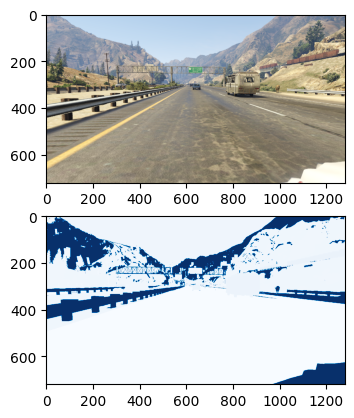

In [6]:
print(f'training dataset contains {gta_train.__len__()} images')
print(f'validation dataset contains {cityscapes_val.__len__()} images')

index = 33
image, sem_map = gta_train.__getitem__(index)
sem_map.size()
fig, axes = plt.subplots(2, 1)
image_transpose = convert_tensor_to_image(image)
map_transpose = convert_tensor_to_image(sem_map)
axes[0].imshow(image_transpose)
axes[1].imshow(map_transpose, cmap='Blues')
plt.show()

In [5]:
# Define the model and load it to the device
model = BiSeNet(num_classes=19, context_path='resnet18')
model.to(device)
epoch = 0 #to initialize the lr
start_lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
l_rate = poly_lr_scheduler(optimizer, init_lr=start_lr , iter=epoch, lr_decay_iter=1, max_iter=50, power=0.9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s] 
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 156MB/s]  


In [6]:
#Freeze model parameters, but in avery fancy way
for param in model.context_path.parameters():
    param.requires_grad = False

In [8]:
from torchinfo import summary
summary(model, input_size=(bs,3,720,1280), col_names=["num_params", "trainable"])

Layer (type:depth-idx)                        Param #                   Trainable
BiSeNet                                       14,630                    Partial
├─Spatial_path: 1-1                           --                        True
│    └─ConvBlock: 2-1                         --                        True
│    │    └─Conv2d: 3-1                       1,728                     True
│    │    └─BatchNorm2d: 3-2                  128                       True
│    │    └─ReLU: 3-3                         --                        --
│    └─ConvBlock: 2-2                         --                        True
│    │    └─Conv2d: 3-4                       73,728                    True
│    │    └─BatchNorm2d: 3-5                  256                       True
│    │    └─ReLU: 3-6                         --                        --
│    └─ConvBlock: 2-3                         --                        True
│    │    └─Conv2d: 3-7                       294,912                   

In [7]:
train_iou_list=[]
train_acc_list=[]
train_loss_list=[]
test_iou_list=[]
class_iou_list=[]
test_acc_list=[]
test_loss_list=[]

In [8]:
# Train the model

epoch_beginning = 0
epochs = 50

for epoch in range(epoch_beginning,epochs):
    n_epoch = epoch+1
    l_rate = poly_lr_scheduler(optimizer, init_lr=start_lr , iter=epoch, lr_decay_iter=1, max_iter=50, power=0.9)
    #train
    train_loss,train_iou,train_acc=train(model, optimizer, train_loader, loss_fn)
    train_iou = np.mean(train_iou)
    train_iou_list.append(train_iou)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    
    #save model
    if n_epoch%5 == 0 or n_epoch==epochs:
        model_name = f"bisenet_GTA5_bs{bs}_epoch{n_epoch}_weights.pth"
        torch.save(model.state_dict(), model_name)
        
    #test    
    test_loss,class_iou,test_acc = test(model, val_loader, loss_fn)
    test_iou = np.mean(class_iou)
    test_iou_list.append(test_iou)
    class_iou_list.append(class_iou)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    f = open("train_iou_list.txt", "a")
    f.write(str(train_iou)+ "\n")
    f.close()
    f = open("test_iou_list.txt", "a")
    f.write(str(test_iou)+ "\n")
    f.close()
    
    print(f"Epoch: {n_epoch}")
    print(f"- Train Acc: {train_acc:.3f}")
#     print(f"- Train Loss: {test_loss:.3f}")
    print(f"- Train mIoU: {train_iou:.3f}\n")
    print(f"- Test Acc: {test_acc:.3f}")
    print(f"- Test Loss: {test_loss:.3f}")
    print(f"- Test mIoU: {test_iou:.3f}")
    if n_epoch==1 or n_epoch == epochs:
        print(f"- Iou per Class: {class_iou}")
    print("__________________________")

Epoch: 1
- Train Acc: 0.724
- Train mIoU: 0.222

- Test Acc: 0.348
- Test Loss: 1.441
- Test mIoU: 0.146
- Iou per Class: [4.85733063e-01 6.26843684e-02 4.32501790e-01 2.43979835e-02
 2.59551115e-02 3.87714883e-02 4.06862618e-04 1.87518630e-03
 5.77674859e-01 5.55926829e-02 5.09816648e-01 5.39676928e-02
 1.92325022e-14 4.65182356e-01 3.46472743e-02 7.46721429e-06
 7.93447689e-03 1.09041695e-13 5.20740580e-15]
__________________________


KeyboardInterrupt: 

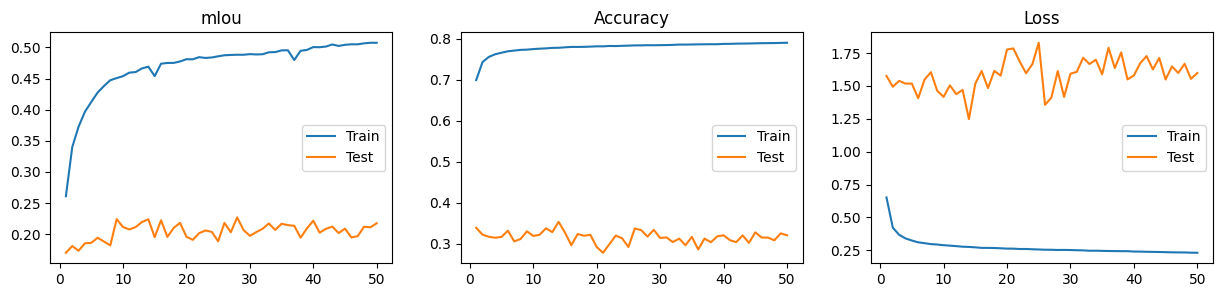

In [11]:
# Plot Graphs
metrics = np.stack(arrays=[train_iou_list ,train_acc_list , train_loss_list, test_iou_list, test_acc_list, test_loss_list], axis=0)

names = ["mIou", "Accuracy", "Loss"]
plotted = 0
plt.figure(figsize=(15,3))
for i in range(len(names)):
    plotted += 1
    plt.subplot(1,3,plotted) 
    plt.plot(range(1, 51), metrics[i], label="Train")
    plt.plot(range(1, 51), metrics[i+len(names)], label="Test")
    plt.title(f"{names[i]}")
    plt.legend()
plt.show()

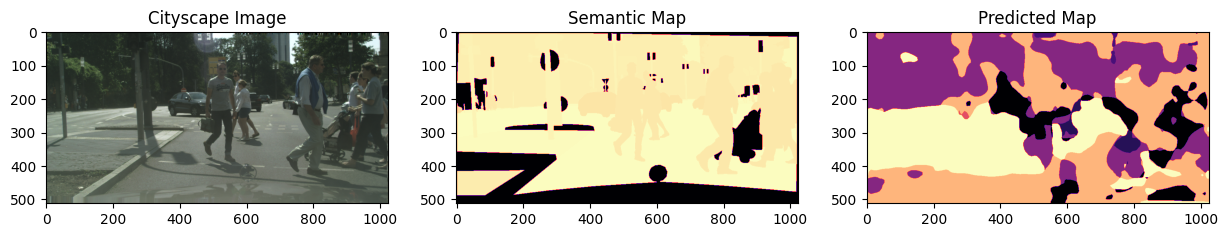

In [11]:
#Generate a custom prediction
import torch.nn as nn
model.eval()
plot_loader = DataLoader(cityscapes_val, batch_size=1, shuffle=True)
img, sem_map = next(iter(plot_loader))
img, sem_map = img.to(device), sem_map.to(device)
img = img.float()
sem_map = sem_map.int()
outputs = model(img)
softmax = nn.Softmax(dim=1)
prediction = torch.argmax(softmax(outputs),axis=1)

plot_prediction(img, sem_map, prediction, c_map="magma_r")

In [ ]:
# FLOPS
from fvcore.nn import FlopCountAnalysis, flop_count_table

plot_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
(input,output) = next(iter(plot_loader))
height = 512
width = 1024

flops = FlopCountAnalysis(model, input.to(device,dtype=torch.float32))
print(flop_count_table(flops))

In [ ]:
# Latency and FPS
import time 
import numpy as np
net = model
net.eval()
fps_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
(inputs, annotations) = next(iter(fps_loader))
inputs=inputs.to(device,dtype=torch.float32)
iterations=1000
latency=np.empty(0)
FPS=np.empty(0)
for i in range(iterations):
    start=time.time()
    output=net(inputs)
    end=time.time()
    latency_i=end-start
    #print(latency_i)
    latency=np.append(latency,latency_i)
    FPS_i=float(1/latency_i)
    FPS=np.append(FPS,FPS_i)
meanLatency=np.mean(latency)
stdLatency=np.std(latency)
meanFPS=np.mean(FPS)
stdFPS=np.std(FPS)

print (f"mean latency: {meanLatency} seconds")
print(f"std latency: {stdLatency} seconds")
print (f"mean FPS: {meanFPS} fps")
print(f"std FPS: {stdFPS} fps")